In [0]:
from google.colab import drive
drive.mount('/content/drive')

!pip install facenet-pytorch 
!pip install mmcv
!pip install albumentations


from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import mmcv, cv2
import albumentations as A
from IPython import display

import albumentations as A

import os, glob, shutil, sys
import time
from functools import reduce

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageDraw

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

display.clear_output()

In [0]:
ABS_PATH = '/content/drive/My Drive/Colab Notebooks/facenet/'
DATA_PATH = ABS_PATH + 'data/'
TRAIN_DIR = DATA_PATH + 'train_images'
TEST_DIR = DATA_PATH + 'test_images'
ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

sys.path.append(ABS_PATH)
from plotter import plot_img, plot_batch, plot_rnd

(1568, 2080) RGB JPEG
(2080, 1568, 3) [0 0 0] [253 245 232]


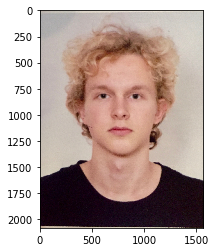

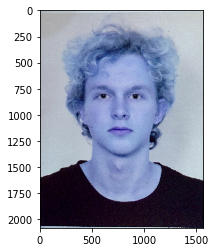

In [0]:
img = Image.open(f'{TRAIN_DIR}/heorgii_bolotov/1.png')
print(img.size, img.mode, img.format)
np_img = np.array(img)
print(np_img.shape, np_img.min(axis=(0, 1)), np_img.max(axis=(0, 1)))
plt.imshow(np_img)
plt.show()
plt.imshow(np_img[..., [2, 1, 0]])
plt.show()

(160, 160) RGB PNG
(160, 160, 3) [28  4 13] [231 198 188]


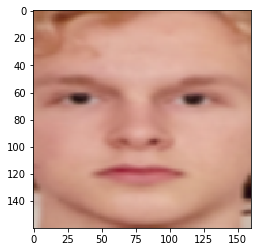

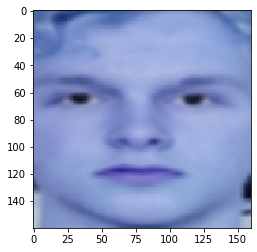

In [0]:
img = Image.open(f'{ALIGNED_TRAIN_DIR}/heorgii_bolotov/1.png')
print(img.size, img.mode, img.format)
np_img = np.array(img)
print(np_img.shape, np_img.min(axis=(0, 1)), np_img.max(axis=(0, 1)))
plt.imshow(np_img)
plt.show()
plt.imshow(np_img[..., [2, 1, 0]])
plt.show()

In [0]:
# plot_by_names(TRAIN_DIR, ['heorgii_bolotov', 'kolya_zubets', 'denis_moroz', 'denis_trishuk', 'danya_nebeskiy'])
# plot_by_names(TEST_DIR, ['heorgii_bolotov', 'kolya_zubets', 'denis_moroz', 'denis_trishuk', 'danya_nebeskiy'])

In [0]:
def get_files(path=ABS_PATH, ext=('.png', '.jpeg', '.jpg')):
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files


def to_rgb_and_save(path):
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB') 
            img.save(p)


def plot_gallery(images, titles, w, h, n_row=2, n_col=5):
    plt.figure(figsize=(2.2 * n_col, 2.4 * n_row))
    # plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.8, hspace=.35)
    # plt.subplots_adjust(bottom=.1, left=.125, right=.9, top=.9, wspace=.2, hspace=.2) # default
    for i in range(n_row * n_col):
        if i == len(images): break 
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i], size=10)
        plt.xticks([]), plt.yticks([])
    

def plot_from_path(path, title='', to_size=(512, 512)):
    images = [Image.open(p).resize(to_size) for p in path]
    titles = [os.path.basename(p) for p in path]
    n_row = int(np.ceil(len(images) / 5))
    n_col = 5 if n_row > 1 else len(images)
    w, h = to_size
    plot_gallery(images, titles, w, h, n_row, n_col)
    plt.suptitle(title)
    plt.show()


def plot_by_names(path, names=None):
    names = os.listdir(path) if not names else names
    for d in os.listdir(path):
        if d in names: 
            d = f'{path}/{d}/*'
            files = glob.glob(d)
            plot_from_path(files)


def crop_face_and_save(path, new_path=None, model=MTCNN, params=None, transformer=None):
    if not new_path: 
        new_path = path + '_cropped'

    if os.path.exists(new_path):
        shutil.rmtree(new_path)

    if not params:
        params = {
            'image_size': 160, 'margin': 0, 
            'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
            'factor': 0.709, 'post_process': False, 'device': device
            }
    
    model = model(**params)

    if not transformer:

        def resize(x): 
            w, h = x.size
            if w > 2000 and h > 2000: 
                return x.resize((1280, 1280))
            return x

        transformer = transforms.Lambda(
            lambd=lambda x: resize(x)
        )

    dataset = datasets.ImageFolder(path, transform=transformer)
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]
    loader = DataLoader(dataset, batch_size=1, collate_fn=training.collate_pil)
    for i, (x, y) in enumerate(loader): 
        model(x, save_path=y)
        print(f'\nBatch {i + 1} of {len(loader)}', end='')

    del model, loader, dataset 

    files, aligned_files = get_files(path), get_files(new_path)
    if len(files) != len(aligned_files):
        files = set([os.path.relpath(f, start=path) for f in files])
        aligned_files = set([os.path.relpath(f, start=new_path) for f in aligned_files])
        dif = list(files - aligned_files)
        print(f"\nfiles {len(aligned_files)}/{len(files)}: {' '.join(dif)} were not saved")
        return [f'{path}/{f}' for f in dif]




# 1
# get path for TRAIN_DIR/TEST_DIR
# tr_f, tst_f = get_files(TRAIN_DIR), get_files(TEST_DIR)


# 2
# convert all img to RGB 
# to_rgb_and_save(tr_f), to_rgb_and_save(tst_f)


# 3
# plot img by path 
# plot_from_path(tr_f, f'TRAIN_DATA total: {len(tr_f)}')
# plot_from_path(tst_f, f'TEST_DATA total: {len(tst_f)}')


# 4
# crop faces from the original dataset and save to new dir 

# TRAIN - files 85/87: denis_trishuk/5.jpeg andrey_boykovskiy/4.png sacha_musak/4.png were not saved
# crop faces and save, func returns files that were not saved   
# tr_fail_f = crop_face_and_save(TRAIN_DIR, ALIGNED_TRAIN_DIR)
# plot original crop-failed images 
# if tr_fail_f:
    # plot_from_path(tr_fail_f, f'ALIGNED_TRAIN_DATA total: {len(tr_fail_f)}', (160, 160))
# plot all cropped images 
# tr_f = get_files(ALIGNED_TRAIN_DIR)
# plot_from_path(tr_f, f'ALIGNED_TRAIN_DATA total: {len(tr_f)}', (160, 160))

# TEST - all saved 
# crop faces and save, func returns files that were not saved   
# tst_fail_f = crop_face_and_save(TEST_DIR, ALIGNED_TEST_DIR)
# plot original crop-failed images 
# if tst_fail_f:
    # plot_from_path(tst_fail_f, f'ALIGNED_TEST_DATA total: {len(tst_fail_f)}', (160, 160))
# plot all cropped images 
# tst_f = get_files(ALIGNED_TEST_DIR)
# plot_from_path(tst_f, f'ALIGNED_TEST_DATA total: {len(tst_f)}', (160, 160))

In [0]:
from sklearn.metrics import pairwise_distances


TR_EMBEDS = os.path.join(DATA_PATH, 'tr_embeds')
TST_EMBEDS = os.path.join(DATA_PATH, 'tst_embeds')


def save_embeddings(file, **kwargs):
    np.savez(file, **kwargs)


def load_embeddings(file):
    if not (file.endswith('.npz') or file.endswith('.npy')):
        file += '.npz'
    return np.load(file)


def get_embedding(model, loader): 
    embeds = []
    cls = []
    for i, (x, y) in enumerate(loader):
        embed = model(x.to(device))
        embeds.append(embed.detach().cpu().numpy())
        cls.extend(y.detach().cpu().numpy())
        print(f'\nBatch {i + 1}/{len(loader)}', '-' * 10)
    embeds = np.concatenate(embeds)
    cls = np.array(cls)
    return embeds, cls 



def get_dists(x, y=None, metric='euclidean', index=None, columns=None):
    dists = pairwise_distances(x, x if y is None else y, metric=metric)
    return pd.DataFrame(dists, index=index, columns=columns)


def plot_heatmap(x, title='', cmap='OrRd', linewidth=1):
    plt.figure(figsize=(17, 12))
    plt.title(title)
    sns.heatmap(x, cmap=cmap, linewidth=linewidth)
    plt.show()


def find_nearest_imgs(x, n, ascending=True): 
    def func(x):
        inds = x.values.argsort()
        inds = inds[:n + 1] if ascending else np.concatenate([inds[0]], inds[::-1][:n])
        return list(zip(inds, x.values[inds]))

    return x.apply(func, axis=1)


def get_fail_dists(inds, samples):
    i_fail = []
    get_ind = lambda i: i[0] if isinstance(i, tuple) else i
    for i, (cls, ind) in enumerate(inds.iteritems() if isinstance(inds, pd.Series) else inds):
        idxs = np.array([samples[get_ind(i)][1] for i in ind])
        if np.any(idxs != idxs[0]): i_fail.append(i) 
    return inds[i_fail]


def plot_nearest(inds, samples, w=160, h=160):
    for i, (cls, ind) in enumerate(inds.iteritems() if isinstance(inds, pd.Series) else inds):
        images, titles = [], []
        path, title_ = None, None
        for i in ind: 
            if isinstance(i, tuple): 
                i_, d = i
                path, idx = samples[i_]
                title_ = f'{IDX_TO_CLS[idx]}: {d:.2f}'
            else: 
                path, idx = samples[i]
                title_ = IDX_TO_CLS[idx]

            titles.append(title_), images.append(Image.open(path))

        plot_gallery(images, titles, w, h, n_row=1, n_col=len(images))    
        plt.show()
     

# Prepare Model 
# model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.5, device=device).eval()

# for p in model.parameters():
    # p.requires_grad_(False)

# Basic transformer for all dataset 
standard_transform = transforms.Compose([
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])

mask = A.Compose([])

apply_mask = lambda img: mask(image=np.array(img))['image']

transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=apply_mask),
                                 standard_transform
    ]),
    'test': standard_transform
}


# Make Train Loader 
tr_d = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
tr_l = DataLoader(tr_d, batch_size=32, num_workers=2
                  # sampler=SubsetRandomSampler(range(len(tr_d)))
                  )

# Make Test Loader 
# tst_d = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=transform['test'])
# tst_l = DataLoader(tst_d, batch_size=32, num_workers=2
                  # sampler=SubsetRandomSampler(range(len(tr_d)))
                  # )

# get Train embeddings & save them
# tr_embeds, tr_cls = get_embedding(model, tr_l)
# save_embeddings(TR_EMBEDS, x=tr_embeds, y=tr_cls)

# get Test embeddings & save them
# tst_embeds, tst_cls = get_embedding(model, tst_l)
# save_embeddings(TST_EMBEDS, x=tst_embeds, y=tst_cls)

# Load Train embeddings 
tr_embeds, tr_cls = load_embeddings(TR_EMBEDS).values()

# Load Test embeddings
tst_embeds, tst_cls = load_embeddings(TST_EMBEDS).values()


# IDX TO CLS 
IDX_TO_CLS = {i: c for c, i in tr_d.class_to_idx.items()}
# names for DataFrame
NAMES = [IDX_TO_CLS[idx] for idx in tr_cls]
# Samples - order of files in Dataset 
SAMPLES = tr_d.samples

In [0]:
TR_AUG_EMBEDS = os.path.join(DATA_PATH, 'tr_aug_embeds')

def get_embeds_ntimes(model, loader, n): 
    embeds = []
    cls = []
    for i in range(n): 
        x, y = get_embedding(model, loader)
        embeds.append(x), cls.append(y)
        display.clear_output()
    embeds, cls = np.concatenate(embeds), np.concatenate(cls)
    print(embeds.shape, cls.shape)
    return embeds, cls


model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.6, device=device).eval()


mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.JpegCompression(p=0.15),
                   A.OneOf([
                            A.Rotate(30, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
], p=1)
apply_mask = lambda img: mask(image=np.array(img))['image']
transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=apply_mask),
                                 standard_transform
    ]),
    'test': standard_transform
}

b = 32
tr_d = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
tr_l = DataLoader(tr_d, batch_size=b, num_workers=2,
                  sampler=SubsetRandomSampler(range(len(tr_d)))
                  )


# tr_aug_embeds, tr_aug_cls = get_embeds_ntimes(model, tr_l, 100)

# save_embeddings(TR_AUG_EMBEDS, x=tr_aug_embeds, y=tr_aug_cls)

tr_aug_embeds, tr_aug_cls = load_embeddings(TR_AUG_EMBEDS).values()

# del model

In [0]:
tr_embeds, tr_cls = load_embeddings(TR_EMBEDS).values()
tr_aug_embeds, tr_aug_cls = load_embeddings(TR_AUG_EMBEDS).values()
# for p in [tr_embeds, tr_cls, tr_aug_embeds, tr_aug_cls]:
    # print(p.shape)

In [0]:
np.concatenate([tr_embeds, tr_aug_embeds]).shape, np.concatenate([tr_cls, tr_aug_cls]).shape

((1785, 512), (1785,))

In [0]:
X, y = np.concatenate([tr_embeds, tr_aug_embeds]), np.concatenate([tr_cls, tr_aug_cls])
X.shape, y.shape

((8585, 512), (8585,))

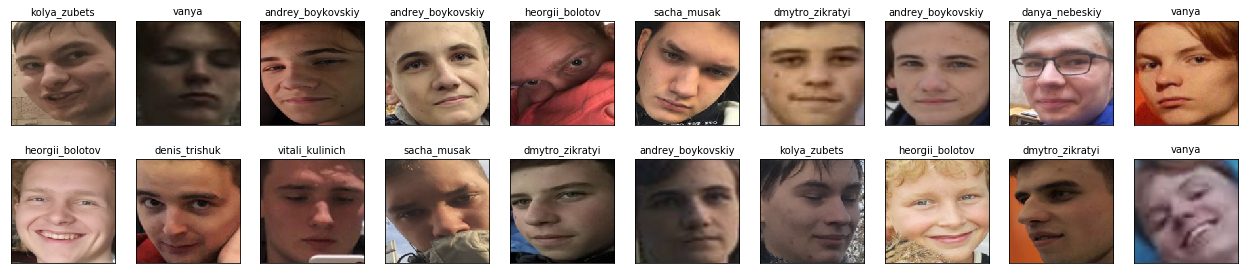

In [0]:
# from albumentations.augmentations import transforms as T

"""
1. Original
2. A.HorizontalFlip(p=1),         
3. A.RandomContrast(limit=0.5, p=1) 
4. 2 + 3
5. A.RandomSizedCrop((120, 120), 160, 160)
6. 2 + 5
7. 2 + 3 + 5
8. 3 + 5
9. A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=1),
10. 5 + 9
11. 2 + 5 + 9 
12. A.HueSaturationValue(p=1, val_shift_limit=10),
13. 2 + 12
14. 3 + 5 + 12
15. A.Rotate(30, p=1)
16. 3 + 5 + 12 + 15
"""
                  # A.HorizontalFlip(p=1), 
                  # A.RandomContrast(limit=0.5, p=1),   
                  # A.RandomSizedCrop((120, 120), 160, 160),
                  # A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=1),
                  # A.HueSaturationValue(p=1, val_shift_limit=10),
                  # A.Rotate(30, p=1)


def get_embeds_ntimes(model, loader, n): 
    embeds = []
    cls = []
    for i in range(n): 
        x, y = get_embedding(model, loader=n)
        embeds.append(x), cls.append(y)
    return embeds, idx
  

save_embeddings(TR_EMBEDS, x=tr_embeds, y=tr_cls)

mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.RandomContrast(limit=0.5, p=0.5),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOf([
                            A.Rotate(30, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5)
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
], p=1)

apply_mask = lambda img: mask(image=np.array(img))['image']

transform = {
    'train': transforms.Compose([
                                 transforms.Lambda(lambd=apply_mask),
                                 standard_transform
    ]),
    'test': standard_transform
}

b = 32
tr_d = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
tr_l = DataLoader(tr_d, batch_size=b, num_workers=2,
                  sampler=SubsetRandomSampler(range(len(tr_d)))
                  )

def unnorm(x):
    x = x.cpu().permute((1, 2, 0)) * 127 + 128
    return x / 255

for x, y in tr_l: 
    x, y = [unnorm(x_i) for x_i in x], [IDX_TO_CLS[y_i] for y_i in y.cpu().numpy()]
    # x = [(x_i - x_i.mean(axis=(0, 1), keepdims=True)) / x_i.std(axis=(0, 1), keepdims=True) for x_i in x]
    # print([x_i.mean() for x_i in x])
    plot_gallery(x, y, w=160, h=160, n_row=(b // 10) + 1, n_col=10 if b >= 10 else b)
    break 

Total: 15


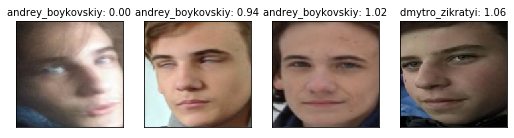

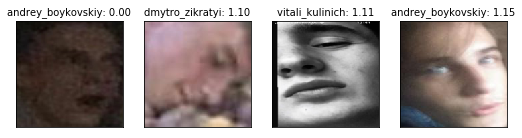

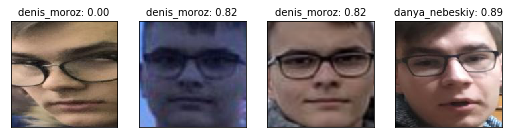

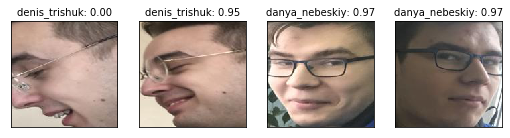

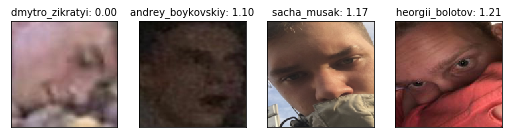

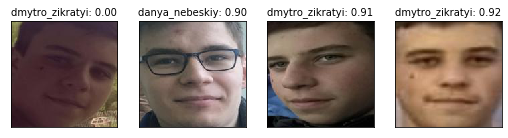

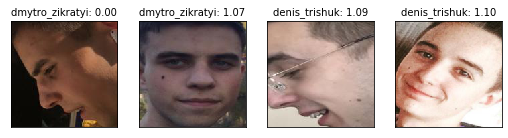

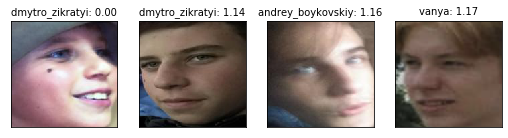

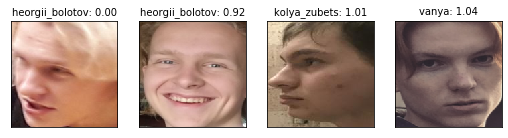

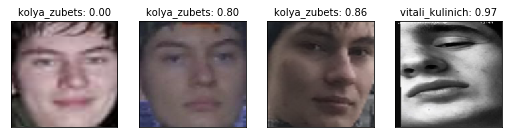

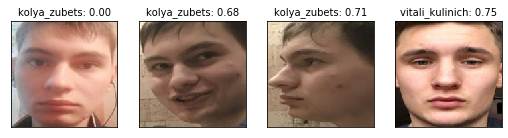

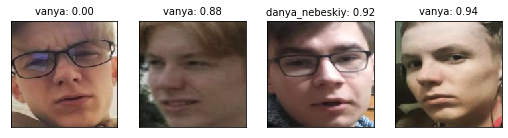

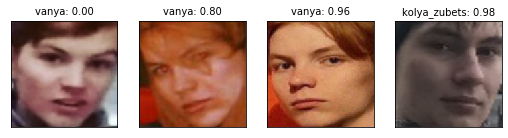

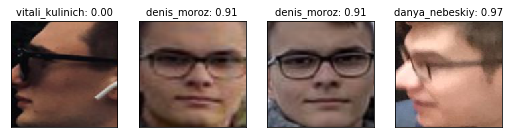

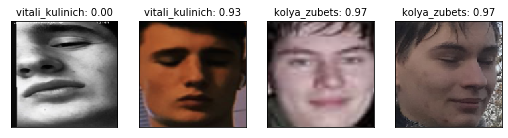

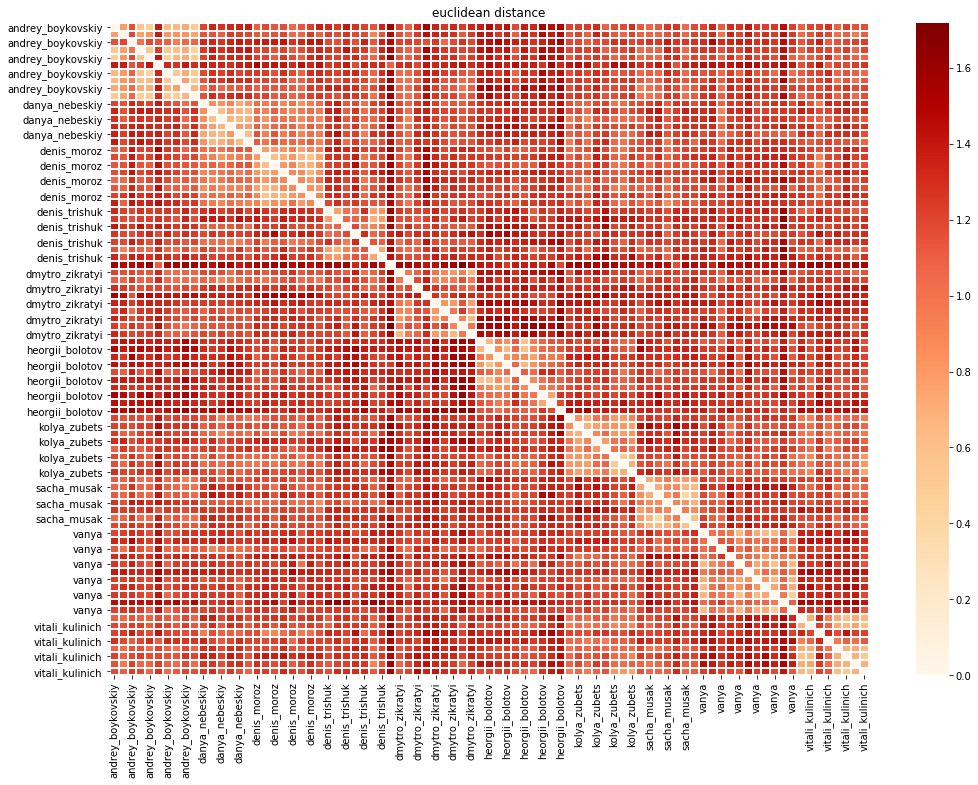

In [0]:
# euclidean
dists = get_dists(tr_embeds, metric='euclidean', index=NAMES, columns=NAMES)
inds = find_nearest_imgs(dists, 3)
inds_fail = get_fail_dists(inds, SAMPLES)
print(f'Total: {len(inds_fail)}')
plot_nearest(inds_fail, SAMPLES)
plot_heatmap(dists, 'euclidean distance')

Total: 15


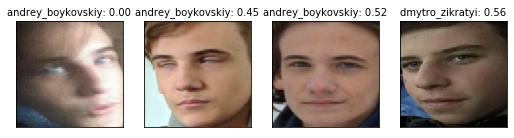

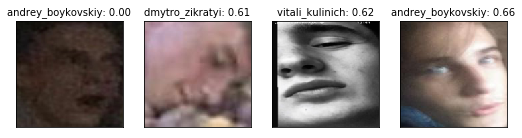

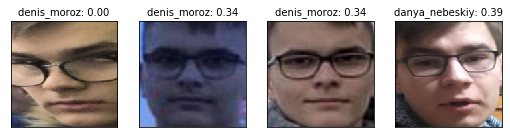

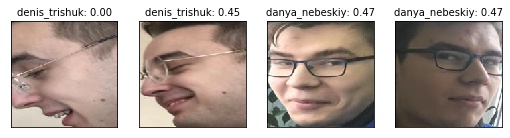

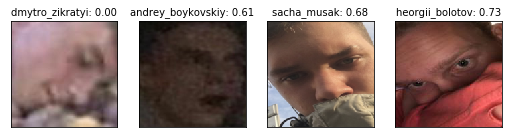

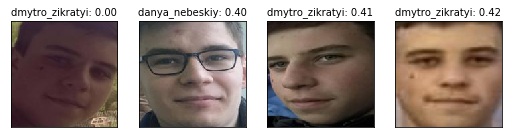

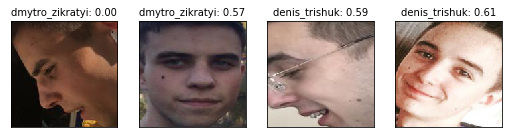

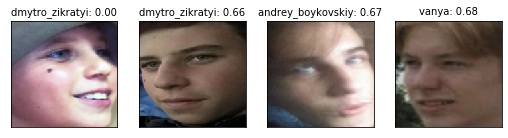

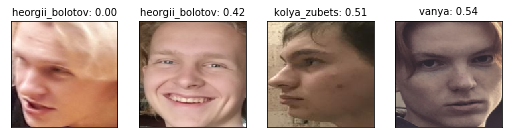

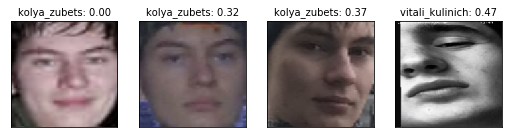

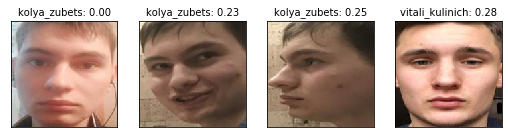

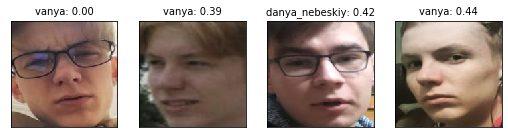

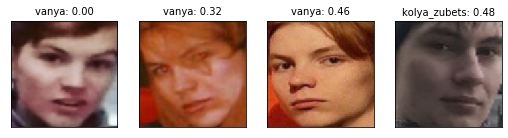

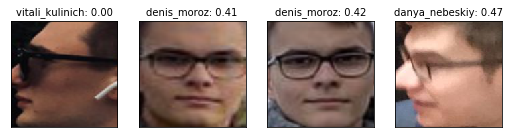

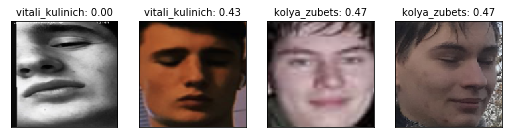

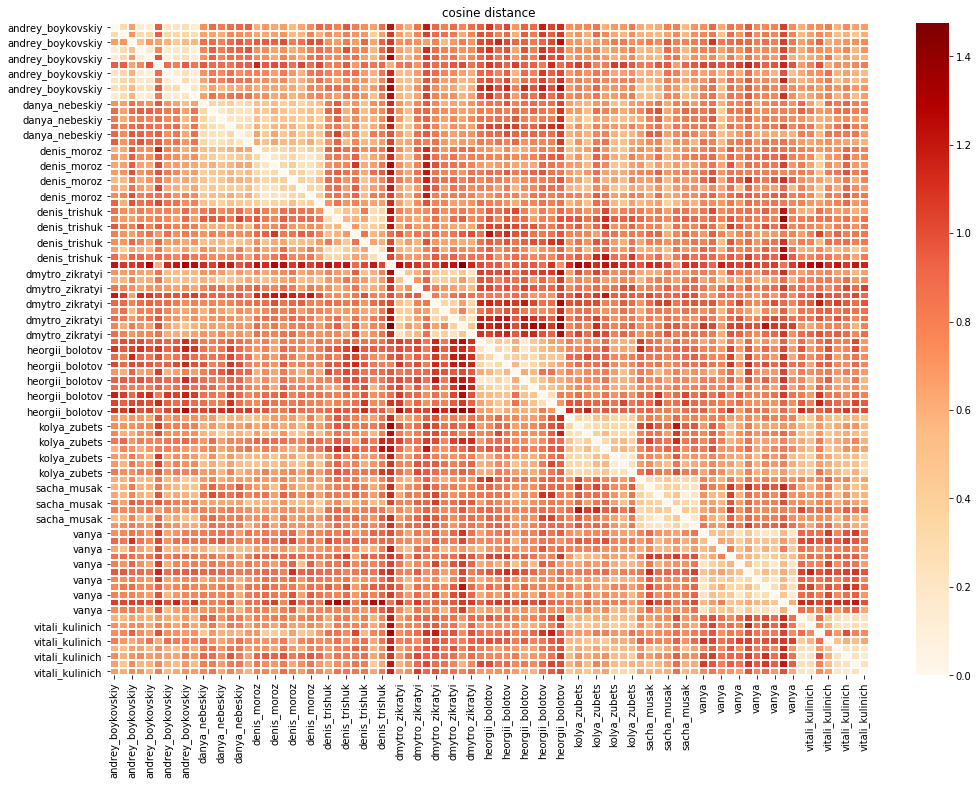

In [0]:
# cosine
dists = get_dists(tr_embeds, metric='cosine', index=NAMES, columns=NAMES)
inds = find_nearest_imgs(dists, 3)
inds_fail = get_fail_dists(inds, SAMPLES)
print(f'Total: {len(inds_fail)}')
plot_nearest(inds_fail, SAMPLES)
plot_heatmap(dists, 'cosine distance')

In [0]:
# X, y = np.concatenate([tr_embeds, tr_aug_embeds]), np.concatenate([tr_cls, tr_aug_cls])
X, y = tr_embeds, tr_cls

In [0]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')

param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 10, 'probability': True, 'random_state': 3}
model = SVC(**model_params)
clf = GridSearchCV(model, param_grid)
clf.fit(X, y)
print(clf.best_estimator_)
# tst_embeds, tst_cls

SVC(C=5000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1,
    kernel='poly', max_iter=10, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
CPU times: user 1h 33min 37s, sys: 552 ms, total: 1h 33min 38s
Wall time: 1h 33min 44s


In [0]:
clf.best_params_

{'C': 5000.0, 'gamma': 0.1, 'kernel': 'poly'}

In [0]:
import joblib
from sklearn.svm import SVC


SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
# best_params = {'C': 5000.0, 'gamma': 0.1, 'kernel': 'poly'}
# clf = SVC(probability=True, random_state=3, max_iter=50, **best_params)
# clf.fit(X, y)

# SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
# joblib.dump(clf, SVM_PATH)

clf = joblib.load(SVM_PATH)

In [0]:
clf.score(X_val, y_val)

1.0

In [0]:
import joblib
from sklearn.svm import SVC


clf = SVC(C=5000, class_weight='balanced', probability=True, kernel='poly', max_iter=100, random_state=3, gamma=0.1)
clf.fit(X, y)

SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
joblib.dump(clf, SVM_PATH)

# clf = joblib.load(SVM_PATH)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


['/content/drive/My Drive/Colab Notebooks/facenet/data/svm.sav']

In [0]:
X_val, y_val = tst_embeds, tst_cls
clf.predict(tst_embeds)

inds = list(range(len(y_val)))
np.random.shuffle(inds)

np.sum(clf.predict(X_val[inds]) == y_val[inds]) / len(y_val)

1.0

In [0]:
p = clf.predict_proba(X_val[inds])
inds = p.argmax(axis=1)
[p[i, inds[i]] for i in range(len(inds))]

[0.9987236279147286,
 0.8750273643757037,
 0.9781209971292179,
 0.6094252352052072,
 0.7767436352203292,
 0.8087174584718485,
 0.9793141676781593,
 0.6328610979291417,
 0.9862022847100945,
 0.9693400762098431]

In [0]:
X_val, y_val = load_embeddings(TST_EMBEDS).values()
inds = list(range(len(y_val)))
np.random.shuffle(inds)

len(y_val) / np.sum(clf.predict(X_val[inds]) == y_val[inds])
# clf.predict(X_val[inds])

1.0

In [0]:
glob.glob(DATA_PATH + '/**/*.mov')

['/content/drive/My Drive/Colab Notebooks/facenet/data/videos/1.mov',
 '/content/drive/My Drive/Colab Notebooks/facenet/data/videos/2.mov']

In [0]:
from IPython.display import HTML
from base64 import b64encode

VIDEO_PATH = os.path.join(DATA_PATH, 'videos/')

mp4 = open(VIDEO_PATH + '1.mov','rb').read()
data_url = "data:video/mov;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
from google.colab.patches import cv2_imshow
import cv2 


VIDEO_PATH = os.path.join(DATA_PATH, 'videos/')

capture = cv2.VideoCapture(VIDEO_PATH + '1.mov')
print(capture.isOpened())
i = 0
while capture.isOpened():
    ret, frame =  capture.read()
    cv2.imshow('Frame', frame)

    # cv2_imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    # plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    if i > 10:
        break 

In [0]:
from PIL import ImageFont
import cv2 


def get_video_embedding(model, x): 
    embeds = model(x.to(device))
    return embeds.detach().cpu().numpy()


VIDEO_PATH = os.path.join(DATA_PATH, 'videos/')
capture = cv2.VideoCapture(VIDEO_PATH + '2.mov')

mtcnn = MTCNN(keep_all=True, min_face_size=25, device=device)

model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.6, device=device).eval()
standard_transform = transforms.Compose([
                                transforms.Resize((160, 160)),
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])

tr_embeds, tr_cls = get_embedding(model, tr_l)

font = ImageFont.truetype(os.path.join(ABS_PATH, 'arial.ttf'), size=22)

i = 0
frames = []
while True:
    ret, frame = capture.read()
    if not ret: 
        break
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    boxes, _ = mtcnn.detect(img)
    if boxes is None: boxes = []

    names, prob = [], []
    if len(boxes): 
        x = torch.stack([standard_transform(img.crop(b)) for b in boxes])
        embeds = get_video_embedding(model, x)
        idx, prob = clf.predict(embeds), clf.predict_proba(embeds).max(axis=1)
        names = [IDX_TO_CLS[idx_] for idx_ in idx]

    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box, name, prob in zip(boxes, names, prob):
        draw.rectangle(box.tolist(), outline=(0, 255, 0), width=4)
        draw.text((box[0], box[1]), f'{name}: {prob.item():.3f}', (255, 255, 255), font)
        # print(abs(box[0] - box[1]), abs(box[2] - box[3]), )
    frames.append(frame_draw.resize((620, 480), Image.BILINEAR))
    i += 1 
    # break 


Batch 1/3 ----------

Batch 2/3 ----------

Batch 3/3 ----------


In [0]:
def diag(x1, y1, x2, y2):
    return np.linalg.norm([x2 - x1, y2 - y1])


def square(x1, y1, x2, y2):
    return abs(x2 - x1) * abs(y2 - y1)


def isOverlap(rect1, rect2):
    x1, x2 = rect1[0], rect1[2]
    y1, y2 = rect1[1], rect1[3]

    x1_, x2_ = rect2[0], rect2[2]
    y1_, y2_ = rect2[1], rect2[3]

    if x1 > x2_ or x2 < x1_: return False 
    if y1 > y2_ or y2 < y1_: return False
  
    rght, lft = x1 < x1_ < x2, x1_ < x1 < x2_
    d1, d2 = 0, diag(x1_, y1_, x2_, y2_)
    threshold = 0.5

    if rght and y1 < y1_: d1 = diag(x1_, y1_, x2, y2)
    elif rght and y1 > y1_: d1 = diag(x1_, y2_, x2, y1)
    elif lft and y1 < y1_: d1 = diag(x2_, y1_, x1, y2) 
    elif lft and y1 > y1_: d1 = diag(x2_, y2_, x1, y1)

    if d1 / d2 >= threshold and square(x1, y1, x2, y2) < square(x1_, y1_, x2_, y2_): return True
    return False

In [0]:
from PIL import ImageFont
import cv2 
from IPython.display import HTML
from base64 import b64encode


# VIDEO_PATH = os.path.join(DATA_PATH, 'videos/2.mov')
# capture = cv2.VideoCapture(VIDEO_PATH + '2.mov')


standard_transform = transforms.Compose([
                                transforms.Resize((160, 160)),
                                np.float32, 
                                transforms.ToTensor(),
                                fixed_image_standardization
])


def get_video_embedding(model, x): 
    embeds = model(x.to(device))
    return embeds.detach().cpu().numpy()


def show_mp4(path):
    mp4 = open(path,'rb').read()
    data_url = "data:video/mov;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)


def save_mp4(frames, path):
    dim = frames[0].size
    fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
    video_tracked = cv2.VideoWriter(path, fourcc, 25.0, dim)
    for frame in frames:
        video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
    video_tracked.release()


def draw_box(draw, boxes, names, probs, min_p=0.91):
    font = ImageFont.truetype(os.path.join(ABS_PATH, 'arial.ttf'), size=22)

    not_overlap_inds = []
    for i in range(len(boxes)): 
        not_overlap = True
        for box2 in boxes: 
            if np.all(boxes[i] == box2): continue 
            not_overlap = not isOverlap(boxes[i], box2)   
            if not not_overlap: break 
        if not_overlap: not_overlap_inds.append(i)

    boxes, probs = [boxes[i] for i in not_overlap_inds], [probs[i] for i in not_overlap_inds]
    for box, name, prob in zip(boxes, names, probs):
        if prob >= min_p: 
            draw.rectangle(box.tolist(), outline=(0, 255, 0), width=4)
            draw.text((box[0], box[1]), f'{name}: {prob:.2f}', (255, 255, 255), font) 
    return boxes, probs 


def face_extract(model, clf, frame, boxes):
    names, prob = [], []
    if len(boxes):
        x = torch.stack([standard_transform(frame.crop(b)) for b in boxes])
        embeds = get_video_embedding(model, x)
        idx, prob = clf.predict(embeds), clf.predict_proba(embeds).max(axis=1)
        names = [IDX_TO_CLS[idx_] for idx_ in idx]
    return names, prob 


def preprocess_video(detector, face_extractor, clf, path, k=3):
    frames = []
    capture = cv2.VideoCapture(path)
    i = 0 
    while True: 
        ret, frame = capture.read()
        if not ret: break 

        iframe = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        if (i + 1) % k: 
            boxes, probs = detector.detect(iframe)
            if boxes is None: boxes, probs = [], []
            names, prob = face_extract(face_extractor, clf, iframe, boxes)
            
        frame_draw = iframe.copy()
        draw = ImageDraw.Draw(frame_draw)

        boxes, probs = draw_box(draw, boxes, names, probs)
        frames.append(frame_draw.resize((620, 480), Image.BILINEAR))
        i += 1
        
    print(f'Total frames: {i}')
    return frames


mtcnn = MTCNN(keep_all=True, min_face_size=70, device=device)
VIDEO_PATH = os.path.join(DATA_PATH, 'videos/')

model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.6, device=device).eval()

frames = preprocess_video(mtcnn, model, clf, VIDEO_PATH + '1.mov')

save_mp4(frames, VIDEO_PATH + '1_tracked.mp4')
# show_mp4(VIDEO_PATH + '2_tracked.mp4')

Total frames: 168


In [0]:
d = display.display(frames[0], display_id=True)
i = 1

try: 
    while True: 
        time.sleep(1.1)
        d.update(frames[i % len(frames)])
        i += 1
except KeyboardInterrupt:
    pass

In [0]:
dim = frames[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter(VIDEO_PATH + '2_tracked.mp4', fourcc, 25.0, dim)
for frame in frames:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

In [0]:
from IPython.display import HTML
from base64 import b64encode

VIDEO_PATH = os.path.join(DATA_PATH, 'videos/')

mp4 = open(VIDEO_PATH + '1_tracked.mp4','rb').read()
data_url = "data:video/mov;base64," + b64encode(mp4).decode()
HTML("""
<video width=640 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.


img1.jpeg, size: (160, 160, 3),  mean: [166.879 127.161 111.517], std: [57.155 46.103 43.692], min/max: [15  9  0]/[255 243 238]

img2.jpeg, size: (160, 160, 3),  mean: [127.868 104.837  99.768], std: [68.481 64.496 64.379], min/max: [ 6 11 12]/[255 255 255]

img3.jpeg, size: (160, 160, 3),  mean: [127.679 116.309 112.838], std: [53.36  48.525 50.095], min/max: [11 15 16]/[255 236 241]

img4.jpeg, size: (160, 160, 3),  mean: [106.998  96.73   90.74 ], std: [47.775 46.689 48.642], min/max: [29 29 27]/[255 255 255]

img5.jpeg, size: (160, 160, 3),  mean: [150.804 131.268 117.127], std: [60.447 49.94  46.258], min/max: [17 29 15]/[255 255 249]

img6.jpg, size: (160, 160, 3),  mean: [157.107 125.37  122.796], std: [51.045 47.523 44.493], min/max: [19 18 23]/[255 255 255]


img1.jpeg, size: (160, 160, 3),  mean: [164.207 127.332 102.949], std: [47.239 41.679 39.489], min/max: [46  8  1]/[235 212 188]

img2.jpeg, size: (160, 160, 3),  mean: [141.29  124.818 102.947], std: [67.203 65.896 67.

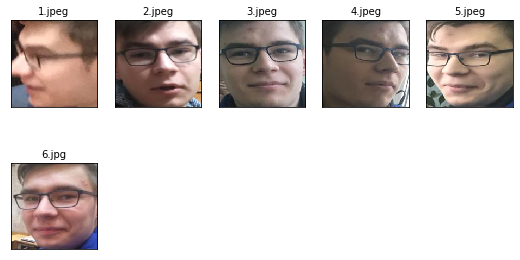

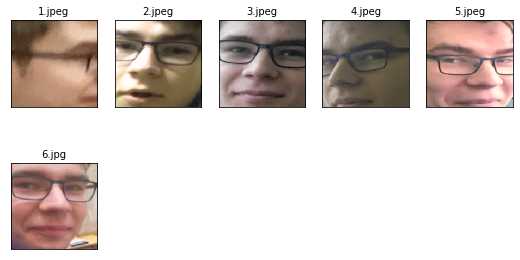

In [0]:
# datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=None)
np.set_printoptions(suppress=True, precision=3)

def stats(images, titles=None):
    titles = range(len(images)) if titles is None else titles
    for img, title in zip(images, titles):
        if Image.isImageType(img):
            img = np.array(img)
        
        min_, max_ = img.min(axis=(0, 1)), img.max(axis=(0, 1)) 
        mean, std = img.mean(axis=(0, 1)), img.std(axis=(0, 1))
        print(f'\nimg{title}, size: {img.shape},  mean: {mean}, std: {std}, min/max: {min_}/{max_}')


mask = A.Compose([
                  A.RandomBrightnessContrast(p=1),
                  A.HorizontalFlip(p=1),
                  A.HueSaturationValue(p=1, val_shift_limit=15),
                  A.RandomSizedCrop((120, 120), 160, 160),
])


mask1 = A.Compose([
                  A.RandomSizedCrop((120, 120), 160, 160),
                  A.HorizontalFlip(p=1)
])
mask2 = A.Compose([
                  A.RandomSizedCrop((120, 120), 160, 160),
                  A.JpegCompression(p=1)
])

mask3 = A.Compose([
                  A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=1),
                  A.HorizontalFlip(p=0.5)
])

apply_mask = lambda img: mask(image=np.array(img))['image']

# names = os.listdir(ALIGNED_TRAIN_DIR)
names = ['danya_nebeskiy']
for d in os.listdir(ALIGNED_TRAIN_DIR):
    if d in names: 
        d = f'{ALIGNED_TRAIN_DIR}/{d}/*'
        files = glob.glob(d)

        images = [Image.open(f) for f in files]
        
        titles = [os.path.basename(f) for f in files]

        n_row = int(np.ceil(len(images) / 5))
        n_col = 5 if n_row > 1 else len(images)

        stats(images, titles)
        plot_gallery(images, titles=titles, w=160, h=160, n_row=n_row, n_col=n_col)
        print()
        images = [apply_mask(img) for img in images]
        stats(images, titles)
        plot_gallery(images, titles=titles, w=160, h=160, n_row=n_row, n_col=n_col)


# plot_by_names(TRAIN_DIR, ['heorgii_bolotov', 'kolya_zubets', 'denis_moroz', 'denis_trishuk', 'danya_nebeskiy'])

In [0]:
from torchsummary import summary

model = InceptionResnetV1(pretrained='vggface2', classify=True, dropout_prob=0.6)

summary(model, ((3, 160, 160)))

In [0]:
from torchsummary import summary

model = InceptionResnetV1(pretrained='vggface2', dropout_prob=0.6)

summary(model, ((3, 160, 160)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 79, 79]             864
       BatchNorm2d-2           [-1, 32, 79, 79]              64
              ReLU-3           [-1, 32, 79, 79]               0
       BasicConv2d-4           [-1, 32, 79, 79]               0
            Conv2d-5           [-1, 32, 77, 77]           9,216
       BatchNorm2d-6           [-1, 32, 77, 77]              64
              ReLU-7           [-1, 32, 77, 77]               0
       BasicConv2d-8           [-1, 32, 77, 77]               0
            Conv2d-9           [-1, 64, 77, 77]          18,432
      BatchNorm2d-10           [-1, 64, 77, 77]             128
             ReLU-11           [-1, 64, 77, 77]               0
      BasicConv2d-12           [-1, 64, 77, 77]               0
        MaxPool2d-13           [-1, 64, 38, 38]               0
           Conv2d-14           [-1, 80,

In [0]:
# datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=None)

plot_by_names(TRAIN_DIR, ['heorgii_bolotov', 'kolya_zubets', 'denis_moroz', 'denis_trishuk', 'danya_nebeskiy'])

In [0]:
# IDX_TO_CLASS = {idx: cls for cls, idx in dataset.class_to_idx.items()}